#Importar librerias

Son las librerias necesarias para la ejecución del codigo, en donde se desarrollan diversas simulaciones de Monte Carlo a diversos grupos de emisoras de acciones.

In [ ]:
#Ejecutar pip en la primera ejecución
#!pip install yahoo-fin --upgrade
#!pip install requests_html

from yahoo_fin import stock_info
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime as dt
import random

import tensorflow as tf
from keras.layers import Dense,Dropout,Conv1D,Input,Flatten,MaxPooling1D
from keras.models import Sequential,load_model
from keras.optimizers import adam_v2
from sklearn.metrics import accuracy_score
from google.colab import drive
drive.mount('/content/drive')
%run '/content/drive/MyDrive/Escrito/Codigo/Portafolio/Datos.ipynb' import *
%run '/content/drive/MyDrive/Escrito/Codigo/Portafolio/Portafolio.ipynb' import *
%run '/content/drive/MyDrive/Escrito/Codigo/Portafolio/Trading_ML.ipynb' import * 


     |████████████████████████████████| 81 kB 9.3 MB/s 
     |████████████████████████████████| 83 kB 2.9 MB/s 
     |████████████████████████████████| 127 kB 60.0 MB/s 
     |████████████████████████████████| 103 kB 48.4 MB/s 
  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-py3-none-any.whl size=13502 sha256=444100a145e90a68b18ff52dacc7900f05a195e600ccd75444217c8efe172ecb
  Stored in directory: /root/.cache/pip/wheels/ed/f7/62/50ab6c9a0b5567267ab76a9daa9d06315704209b2c5d032031
  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24591 sha256=2b4acf4bcf8e253fee212afcfd601e090a136bafa84d2c7bc901323035762ae5
  Stored in directory: /root/.cache/pip/wheels/9c/aa/cc/f2228050ccb40f22144b073f15a2c84f11204f29fc0dce028e
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6065 sha256=6b4ea44feca054f5e0b25cd13a2fba1536b6a503bb99fbfe186afcfabf441a84
  Stored in directory: /root/.cache/pip/wheels/73/ad/a4/0dff4a6ef231fc0dfa12ffbac2a36ce

#Asignación de Variables 

Lista de las emisoras a extraer información, así como las fechas iniciales y finales de la información requerida.

In [ ]:
fecha_inicio='2020-01-01'
fecha_final="2021-05-30"

#Carga empresas a evaluar
emp= pd.read_csv('/content/drive/MyDrive/Escrito/Codigo/Portafolio/Emisoras.csv',encoding='latin-1')   #Actualizar Ruta del archivo
emp.head()

#Definición de emisoras 
lista_emp= np.array(emp['Emisora'])

In [ ]:
#Fechas de extracción de información
fecha_ini='2020-01-01'
hoy='2021-09-30'

base= preciost(lista_emp,fecha_ini,hoy)
base.index.name='Date'
base.to_csv('/content/precios.csv')

#Extracción de información
Se extraen los precios de cierre y los niveles de volumen generado por cada una de la acciones estudiadas

In [ ]:
#Precios de cierre de las acciones
precio=precios(lista_emp,fecha_inicio,fecha_final)
#Calculo de rendimientos de los precios obtenidos
rend=rendimientos(precio)
#Rendimiento esperado y riesgo de cada acción
metricasRV(rend)

,Media,Riesgo
AC.MX,0.000553,0.014928
ACTINVRB.MX,0.000654,0.014449
AEROMEX.MX,-0.000411,0.038976
AGUA.MX,0.003931,0.029147
ALFAA.MX,0.000670,0.031455
...,...,...
WMT.MX,0.000364,0.015019
WYNN.MX,0.001653,0.034274
X.MX,0.004407,0.047208
XOM.MX,0.000655,0.025404


In [ ]:
#Niveles de volumenes de cada una de las acciones
volum=volums(lista_emp,fecha_inicio,fecha_final)
volum

/usr/local/lib/python3.7/dist-packages/yahoo_fin/stock_info.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame['ticker'] = ticker.upper()


,AC.MX,ACTINVRB.MX,AEROMEX.MX,AGUA.MX,ALFAA.MX,ALPEKA.MX,ALSEA.MX,AMXL.MX,ARA.MX,ASURB.MX,AUTLANB.MX,AXTELCPO.MX,AZTECACPO.MX,BACHOCOB.MX,BBAJIOO.MX,BIMBOA.MX,BOLSAA.MX,BSMXB.MX,CEMEXCPO.MX,CHDRAUIB.MX,CUERVO.MX,DANHOS13.MX,ELEKTRA.MX,FEMSAUBD.MX,FIBRAHD15.MX,FIBRAMQ12.MX,FIBRAPL14.MX,FIHO12.MX,FINN13.MX,FMTY14.MX,FNOVA17.MX,FPLUS16.MX,FSHOP13.MX,FUNO11.MX,GAPB.MX,GCARSOA1.MX,GCC.MX,GENTERA.MX,GFAMSAA.MX,GFINBURO.MX,...,GM.MX,GOOGL.MX,INO.MX,INTC.MX,JNJ.MX,JPM.MX,KO.MX,MA.MX,MCD.MX,MGM.MX,MRNA.MX,MSFT.MX,MU.MX,NCLHN.MX,NFLX.MX,NKE.MX,NOKN.MX,NVDA.MX,PFE.MX,PINS.MX,PG.MX,PYPL.MX,QCOM.MX,RCL.MX,SBUX.MX,SPCE.MX,SQ.MX,T.MX,TCEHYN.MX,TSLA.MX,TWTR.MX,UAL.MX,UBER.MX,V.MX,WFC.MX,WMT.MX,WYNN.MX,X.MX,XOM.MX,ZM.MX
2020-01-02,574468,0,204249,283416,3605877,447365,659390,21236035,326418,110011,10068,116739,883255,26307,683460,1921093,237146,319590,38630092,229416,266135,189386,6660,1358420,19047,604196,159798,226677,10699,152281,0,3475,2458,3385260,470187,265615,404998,509111,1904,1578452,...,0,125,0.0,52,0,1799,340,905,268,0,0,5572,1452,0.0,13827,211,38425,4768,2037,0,39,644,61,0,705,0.0,0.0,448,431.0,4545,24001,0,0.0,2554,24,211,0,8771,0,0.0
2020-01-03,602320,5999,71054,104454,4177223,1191460,1168534,33445053,281669,268701,5765,152200,1968431,35056,898901,1480200,401382,514472,19123326,359241,210826,548934,6871,1961040,178768,529753,253424,134777,153823,98921,0,112448,281258,4001843,549397,412438,351755,1578030,701,2071305,...,0,94,0.0,564,2555,160,0,134,96,1470,0,1904,20193,0.0,1384,2377,180,8016,0,0,212,804,896,0,6529,0.0,0.0,125,1015.0,6270,19500,0,0.0,4626,0,0,5,30635,1549,0.0
2020-01-06,512304,0,258544,206396,2999994,180393,452584,26351065,133976,190601,239165,364009,2407793,89834,771492,868430,535050,1797275,13614055,273501,411507,235464,50807,2005292,505032,767251,226135,95996,97739,103062,0,0,55877,4866519,355421,290660,153010,3880363,6232,1445727,...,0,544,0.0,20,0,188,71,1269,5416,2230,0,5080,18346,0.0,4755,730,5550,5380,3249,0,2526,3319,6971,49,9278,0.0,0.0,1828,226.0,2615,20144,108,0.0,119,0,1024,0,20923,2091,0.0
2020-01-07,1788904,9607,104721,4126917,3496828,642222,1251757,38103399,155144,181670,24562,495393,1065707,67025,1331051,1167362,439525,8206377,26746909,483713,998092,1525013,96624,4373747,5053738,1562694,183303,95617,56846,465100,0,0,2231,3737015,633744,350221,323833,4745163,3408,1773533,...,867,1031,0.0,0,3086,3747,16,330,3788,50146,0,5329,146485,1300.0,4934,476,895,16916,24,0,51,1027,134,0,3577,0.0,0.0,0,1586.0,6590,33138,299,0.0,1583,385,26201,0,33565,1181,0.0
2020-01-08,1106947,1918,362408,520644,4687691,1101920,1095439,51237262,778772,273906,12953,446589,618904,3135467,1884383,1531001,722397,1417694,29105133,2656238,547371,674822,31925,1348368,322248,454837,262420,96501,13862,433612,0,17182,27398,3951491,1417725,384361,316584,1893193,11829,2105344,...,2160,397,0.0,9,205,164,22,733,40030,1450,0,8168,13374,0.0,2984,390,5572,5364,19,0,6201,4347,455,0,650,0.0,0.0,27,6746.0,24535,29083,4937,0.0,2577,333,1358,146,1726,1045,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-24,738484,20183,273208,64092,3025731,646120,1306203,20605749,782264,227295,60816,385445,572528,160188,1311059,2517711,296664,2729810,11219987,381364,481468,399751,36263,724829,331,640500,294710,26385,52235,234539,248,0,1452,2893109,443322,231442,185709,1242441,18013,2103422,...,734,319,5529.0,0,80,610,105,17,109,228,2343,4115,26249,0.0,406,2102,1902,25840,997,11525,49,2294,409,1610,3085,62056.0,2898.0,1880,0.0,2700,13285,2193,2557.0,2905,4031,412,1019,14376,4276,258.0
2021-05-25,2134320,13277,667582,140740,3855457,1429341,1566898,26613645,557661,370268,8804,234059,122783,68213,2269263,3751413,5742252,265473,18420020,358916,484353,922268,74895,1692078,100,1890158,214

#Simulación de portafolios
Se emplean las técnicas de MonteCarlo para la simulación de posibles portafolios de inversión generados con la información de los precios previamente obtenida.

Index(['AC.MX', 'ACTINVRB.MX', 'AEROMEX.MX', 'AGUA.MX', 'ALFAA.MX',
       'ALPEKA.MX', 'ALSEA.MX', 'AMXL.MX', 'ARA.MX', 'ASURB.MX',
       ...
       'TWTR.MX', 'UAL.MX', 'UBER.MX', 'V.MX', 'WFC.MX', 'WMT.MX', 'WYNN.MX',
       'X.MX', 'XOM.MX', 'ZM.MX'],
      dtype='object', length=138)
Index(['PAPPEL.MX', 'FCX.MX', 'TSLA.MX', 'PINS.MX', 'MRNA.MX'], dtype='object')
Index(['AMXL.MX', 'HOMEX.MX', 'CEMEXCPO.MX', 'WALMEX.MX', 'ALFAA.MX',
       'FUNO11.MX', 'GMEXICOB.MX', 'GFNORTEO.MX', 'KIMBERA.MX', 'GENTERA.MX'],
      dtype='object')


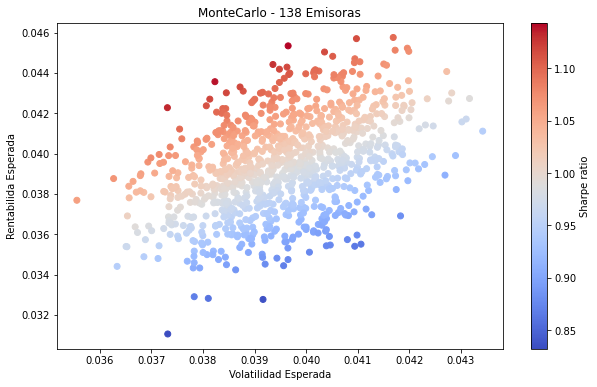

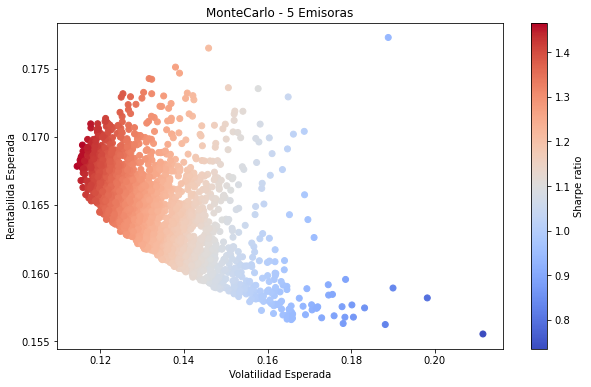

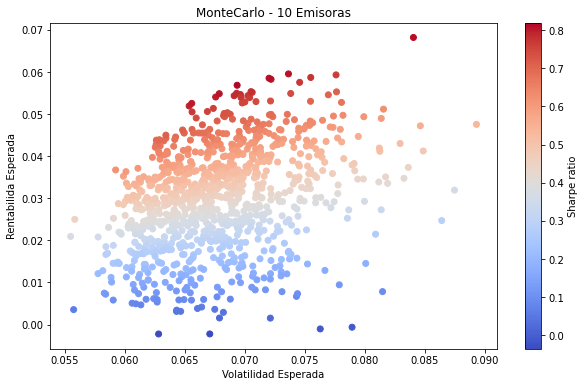

In [ ]:
#Simulación empleado toda la muestra de acciones (139)
MonteCarlo(rend,1000)
#Simulación con los mejores 10 rendimientos esperados
MonteCarlo(rend[top(rend,5)],2000)
#Simulación con los mejores 10 niveles de volumenes promedio
MonteCarlo(rend[top(volum,10)],1000)

#Niveles de rendimiento y riesgo (Rendimiento)
Se calculan los niveles de rendimiento y riesgo a través del rendimiento generado por cada acción

#Rendimientos,Volatilidades y Sharpe Ratio en diversos portafolio de inversión calculados a través de la maximización del Sharpe Ratio

range(2, 139) [0.17562190548052603, 0.17217856839061668, 0.17047988515072035, 0.16889467010180836, 0.15941289745634216, 0.15531081007432002, 0.15531215391826064, 0.15484428647739573, 0.144423902363676, 0.14175840720265054, 0.139234914032601, 0.1349626323894387, 0.134964489682372, 0.13407045040967908, 0.1331518109309326, 0.13314849241142673, 0.12988795296499894, 0.12486168627370371, 0.1240441647832634, 0.12259132757875614, 0.12252924671393312, 0.1225481656701332, 0.1225521129635567, 0.11633860160716732, 0.11634754126946831, 0.11541415688451023, 0.11391800950562317, 0.11390928796862411, 0.1139156368783952, 0.11391051503424221, 0.11390831847269539, 0.1139086225781245, 0.11390655847449326, 0.11390632460655267, 0.11392149345334965, 0.1139106232460121, 0.11389809406969197, 0.11029428380433398, 0.11029461824157666, 0.10607326618752122, 0.10607150312455264, 0.10606495215554324, 0.1060638455482705, 0.10605020699513525, 0.10606516107654945, 0.10606061440438455, 0.10606085315184793, 0.10296785316

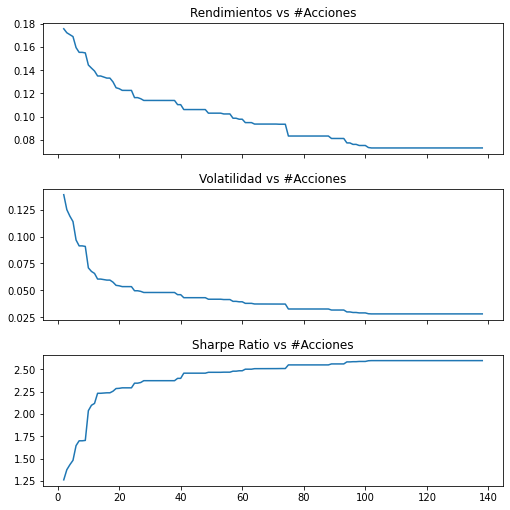

In [ ]:
nivel_SR(rend)

#Rendimientos,Volatilidades y Sharpe Ratio en diversos portafolio de inversión calculados a través de la maximización del Rendimiento sin restricción de volatilidad.

range(2, 139) [0.1828964072920495, 0.1828964072920495, 0.18289640729204953, 0.18289640729204956, 0.1828964072920495, 0.18289640729204956, 0.1828964072920496, 0.1828964072920497, 0.18289640729204984, 0.18289640729204953, 0.1828964072920496, 0.18289640729205, 0.18289640729204965, 0.18289640729204965, 0.18289640729204956, 0.18289640729204965, 0.18289640729204978, 0.18289640729204956, 0.18289640729204953, 0.18289640729204956, 0.18289640729204962, 0.18289640729204956, 0.1828964072920496, 0.18289640729205003, 0.1828964072920497, 0.18289640729204967, 0.18289640729204978, 0.18289640729204962, 0.18289640729204984, 0.18289640729204973, 0.18289640729204962, 0.18289640729204992, 0.18289640729204956, 0.18289640729204984, 0.18289640729204967, 0.1828964072920498, 0.1828964072920497, 0.18289640729204973, 0.18289640729204978, 0.18289640729204967, 0.1828964072920502, 0.18289640729204965, 0.18289640729204976, 0.18289640729204965, 0.1828964072920501, 0.18289640729204965, 0.18289640729204992, 0.18289640729

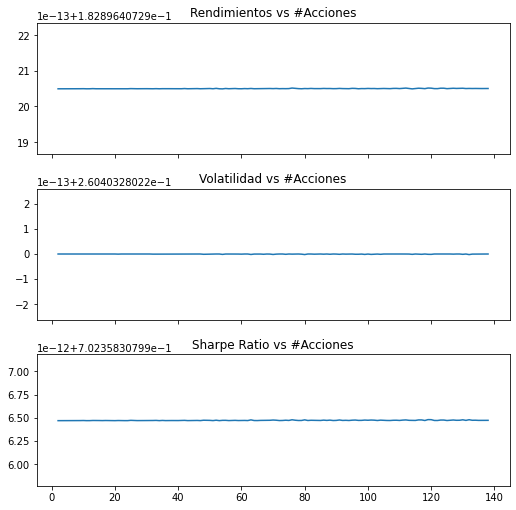

In [ ]:
nivel_RM(rend)

#Rendimientos,Volatilidades y Sharpe Ratio en diversos portafolio de inversión calculados a través de la maximización del Sharpe Ratio con mínima volatilidad.

range(2, 139) [0.17543578604845983, 0.17172911930477766, 0.16988251461756676, 0.16813283546196578, 0.15678801330887188, 0.15154535576527925, 0.15104344480745988, 0.1504736735051765, 0.1404429327200485, 0.13762794277872512, 0.1331699116092947, 0.12896328156568315, 0.12896328035573779, 0.12634114498240784, 0.1227310486999775, 0.12271031857933751, 0.1158865733624685, 0.10760810936792245, 0.10549213258381623, 0.10346203677889107, 0.10278122543157715, 0.09927281532786976, 0.09927280681337106, 0.09185660715575907, 0.09026528027187723, 0.08922119573031362, 0.08795874090439028, 0.08759968466119605, 0.08759968510290488, 0.08741893132233589, 0.08664881400380026, 0.08664881297758842, 0.08635825114451759, 0.08572542424337447, 0.08445573372156572, 0.08346658542393527, 0.08293546738384121, 0.08199651156060521, 0.08120425524113879, 0.0784652382273255, 0.0771006253695491, 0.07695061978888014, 0.07580190413871521, 0.0758019025070084, 0.07580190379957932, 0.07580190318838656, 0.07580189931768401, 0.0733

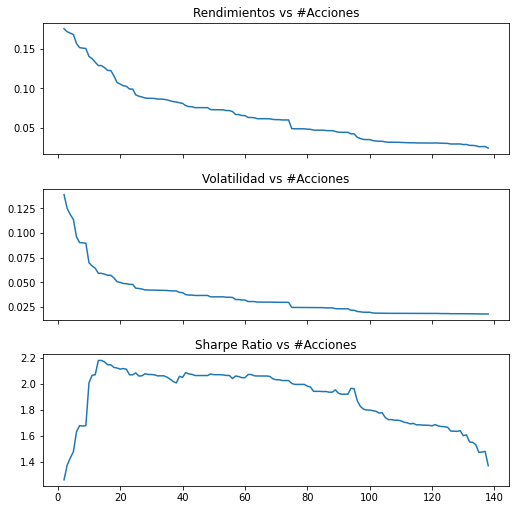

In [ ]:
nivel_RM(rend)

#Rendimientos,Volatilidades y Sharpe Ratio en diversos portafolio de inversión calculados a través de la manimización de la volatilidad o riesgo de la cartera

range(2, 139) [0.17550561991879127, 0.17172836556537754, 0.16987983853205987, 0.16813250068492028, 0.15679043796915343, 0.15156613326278356, 0.15109344843376543, 0.15049831986908407, 0.14040040321524852, 0.1376285152441303, 0.13312028075284693, 0.12896698167258652, 0.12895377680949444, 0.12635461690902658, 0.12269266707417747, 0.1227658635300097, 0.1158462382473678, 0.10763524701068551, 0.1055045704074219, 0.1034874481879668, 0.10283450493598513, 0.09930363402821636, 0.0993188818523891, 0.09179259846735904, 0.09023197570741856, 0.0891891297736765, 0.08789876239543802, 0.08754062504162789, 0.08754357390129643, 0.08733368314139629, 0.08658140104475022, 0.0866099034645073, 0.08629829176654692, 0.08567074377564764, 0.08441145016710304, 0.08343721385390307, 0.08293158453218923, 0.08190544003688342, 0.08111894153586954, 0.07842803974472737, 0.0770648895206132, 0.0769193169265391, 0.07580497276598935, 0.0758171491668271, 0.07582106446209716, 0.07581942539922949, 0.0758179713148114, 0.07327639

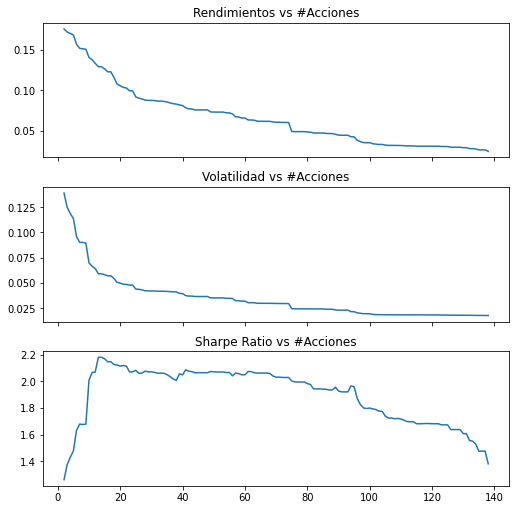

In [ ]:
nivel_MR(rend)

#Niveles de rendimiento y riesgo (Volumen)
Se calculan los niveles de rendimiento y riesgo a través del volumen generado por cada acción

#Rendimientos,Volatilidades y Sharpe Ratio en diversos portafolio de inversión calculados a través de la maximización del Sharpe Ratio

range(2, 139) [0.004481545192954622, 0.13320093872442804, 0.11798618310749806, 0.11813738057915164, 0.11676389134517937, 0.10930892096362614, 0.10674631448454348, 0.10675147974098552, 0.10675416681572371, 0.1067579053183102, 0.1012017891978829, 0.10120096215493217, 0.10217210834342838, 0.09746109333266062, 0.09746509195476129, 0.08913345667550927, 0.08607873521097265, 0.08339487752429117, 0.08309921538779401, 0.0818514885168502, 0.0774784400782905, 0.07746297469723917, 0.07723965381796731, 0.0772385572472852, 0.08105003038115352, 0.08105053794667379, 0.08120115729497338, 0.08120377150334512, 0.08119346492685406, 0.08866092289375685, 0.08867499395763698, 0.0831894938155124, 0.08317300228162579, 0.08289945330848353, 0.08290296079690057, 0.0829100087921398, 0.07943601576488006, 0.07944385591124657, 0.07733625483714619, 0.07731503399180836, 0.07731921486136609, 0.07732074364440036, 0.0773240619209627, 0.0773137719606148, 0.08515336045499151, 0.08447826245890974, 0.08446882502421826, 0.0844

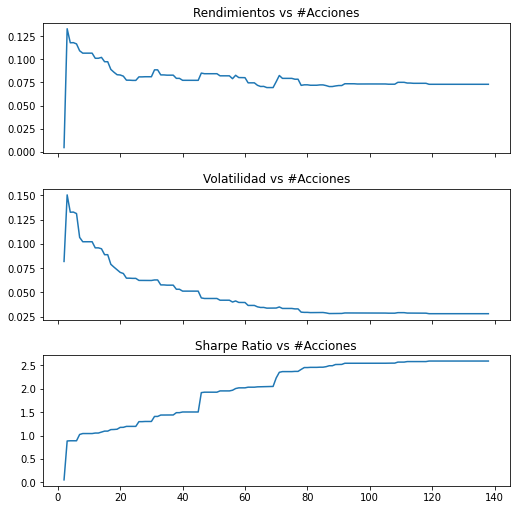

In [ ]:
nivel_vol_SR(rend,volum)

#Rendimientos,Volatilidades y Sharpe Ratio en diversos portafolio de inversión calculados a través de la maximización del Rendimiento

range(2, 139) [0.0044815451929547155, 0.1332009387244279, 0.13320093872442804, 0.13320093872442795, 0.13320093872442795, 0.13320093872442804, 0.13320093872442798, 0.133200938724428, 0.13320093872442804, 0.13320093872442804, 0.13320093872442798, 0.133200938724428, 0.1332009387244281, 0.13320093872442795, 0.13320093872442812, 0.133200938724428, 0.13320093872442804, 0.1332009387244281, 0.1332009387244279, 0.133200938724428, 0.13320093872442806, 0.13320093872442795, 0.13320093872442798, 0.133200938724428, 0.133200938724428, 0.13320093872442826, 0.13320093872442812, 0.133200938724428, 0.1332009387244279, 0.1358347513995111, 0.13583475139951093, 0.135834751399511, 0.13583475139951173, 0.13583475139951096, 0.13583475139951087, 0.13583475139951126, 0.13583475139951104, 0.13583475139951082, 0.13583475139951096, 0.13583475139951073, 0.1358347513995109, 0.13583475139951093, 0.13583475139951112, 0.13583475139951146, 0.135834751399511, 0.13583475139951098, 0.13583475139951123, 0.13583475139951168, 

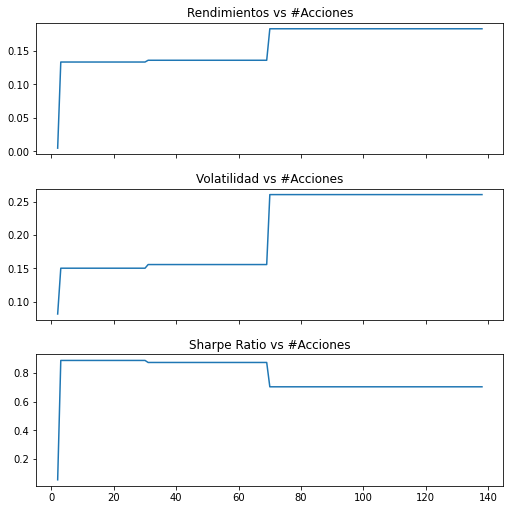

In [ ]:
nivel_vol_RM(rend,volum)

#Rendimientos,Volatilidades y Sharpe Ratio en diversos portafolio de inversión calculados a través de la minimización de la volatilidad o riesgo

range(2, 139) [-0.015857456429713156, 0.004542922573180981, 0.007473955916382354, 0.007587800505796831, 0.007538478187921147, 0.013608938284832074, 0.013432263222247238, 0.00769463608177735, 0.007905718305063777, 0.00836760380295868, 0.009842281729679466, 0.00979743202226161, 0.009837466939316319, 0.01152401047684575, 0.011869058296031056, 0.015258437812815018, 0.0165216406658368, 0.01769592425093033, 0.019384731993475564, 0.02022706471352319, 0.021456264478554993, 0.019442521488491633, 0.019112261653255743, 0.018821041538953982, 0.023316065048568216, 0.022456589609301813, 0.02246906518927758, 0.02108179823490542, 0.020521822692122618, 0.020526919993355566, 0.020530479483200515, 0.02374551943937368, 0.024634783061704517, 0.024894071731554408, 0.025218494353633547, 0.02521646042655846, 0.02623337555606769, 0.025209921005377795, 0.0263748140530155, 0.026139435902944996, 0.027048207379112912, 0.026883392668183324, 0.02601421970239023, 0.026012573166355163, 0.03764946142782413, 0.038201719

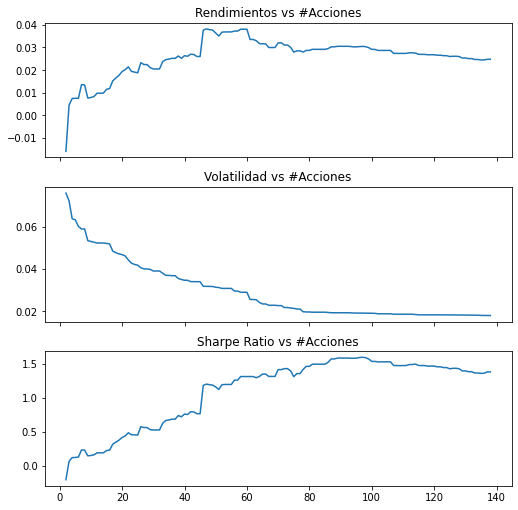

In [ ]:
nivel_vol_MR(rend,volum)

#Simulación de Montecarlo
Aplicación de MonteCarlo para la construcción de diferentes portafolios de inversión

Index(['PAPPEL.MX', 'FCX.MX', 'TSLA.MX', 'PINS.MX', 'MRNA.MX', 'VOLARA.MX',
       'CEMEXCPO.MX', 'X.MX', 'SPCE.MX', 'TRAXIONA.MX'],
      dtype='object')
Index(['PAPPEL.MX', 'FCX.MX', 'TSLA.MX', 'PINS.MX', 'MRNA.MX', 'VOLARA.MX',
       'CEMEXCPO.MX', 'X.MX', 'SPCE.MX', 'TRAXIONA.MX', 'AGUA.MX', 'SQ.MX',
       'ARA.MX', 'MGM.MX', 'TLEVISACPO.MX', 'F.MX', 'GM.MX', 'GMEXICOB.MX',
       'AUTLANB.MX', 'GFNORTEO.MX'],
      dtype='object')
Index(['PAPPEL.MX', 'FCX.MX', 'TSLA.MX', 'PINS.MX', 'MRNA.MX', 'VOLARA.MX',
       'CEMEXCPO.MX', 'X.MX', 'SPCE.MX', 'TRAXIONA.MX', 'AGUA.MX', 'SQ.MX',
       'ARA.MX', 'MGM.MX', 'TLEVISACPO.MX', 'F.MX', 'GM.MX', 'GMEXICOB.MX',
       'AUTLANB.MX', 'GFNORTEO.MX', 'GE.MX', 'AZTECACPO.MX', 'NVDA.MX',
       'NCLHN.MX', 'GCC.MX', 'TWTR.MX', 'ORBIA.MX', 'BBAJIOO.MX', 'BIDUN.MX',
       'RCL.MX'],
      dtype='object')
Index(['PAPPEL.MX', 'FCX.MX', 'TSLA.MX', 'PINS.MX', 'MRNA.MX', 'VOLARA.MX',
       'CEMEXCPO.MX', 'X.MX', 'SPCE.MX', 'TRAXIONA.MX', 'AGUA.MX

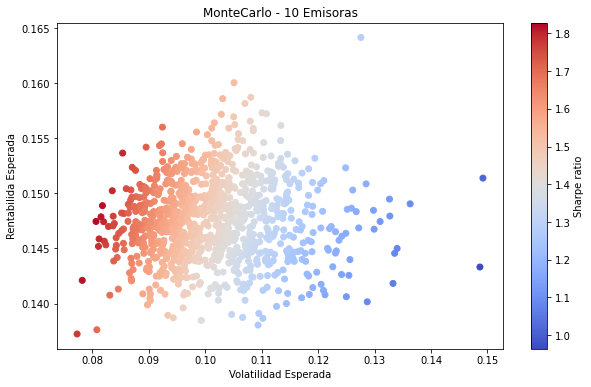

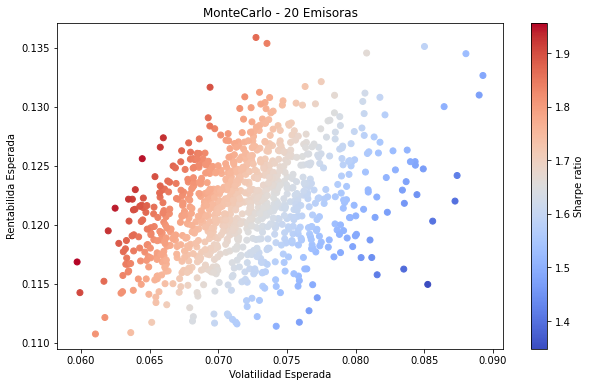

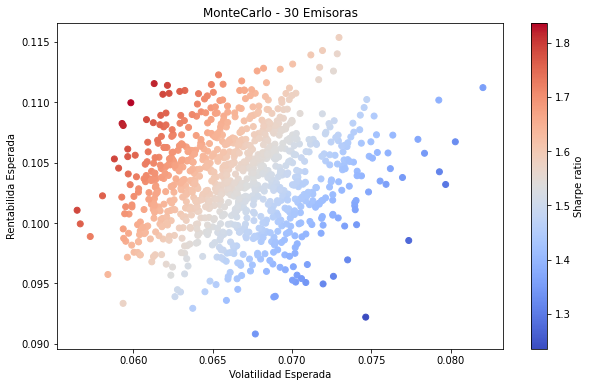

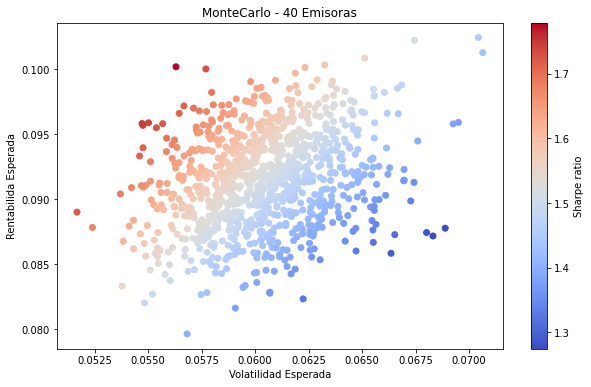

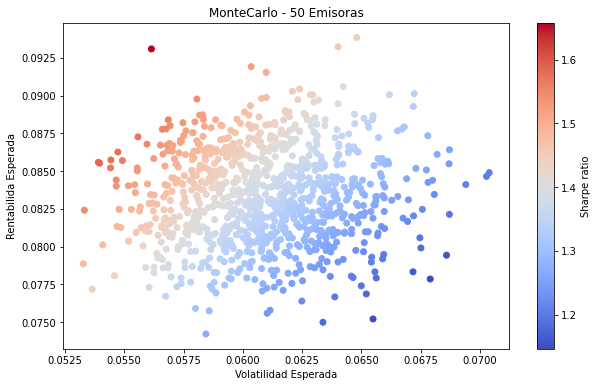

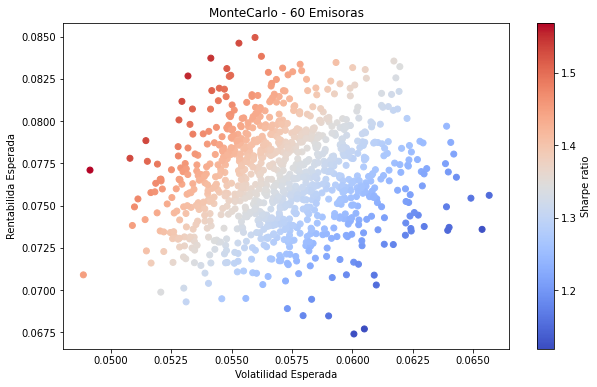

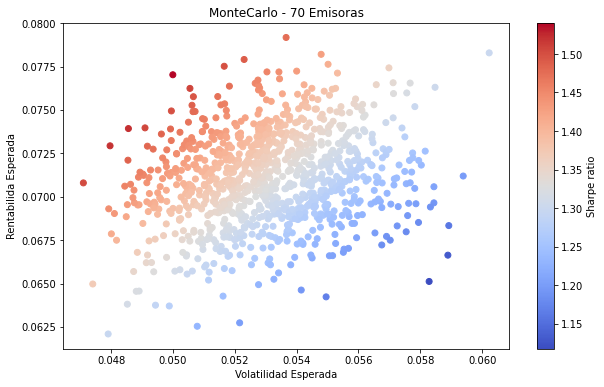

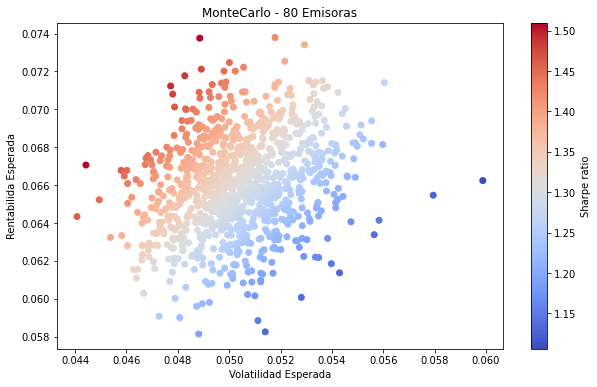

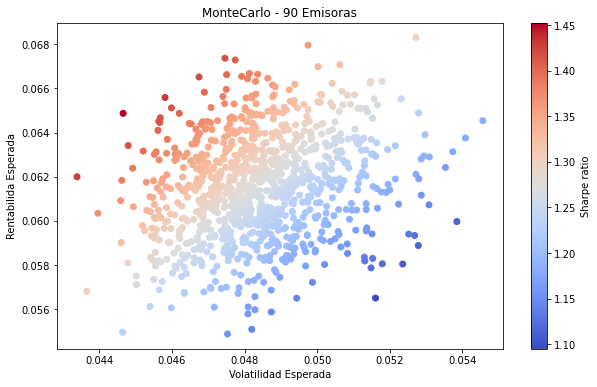

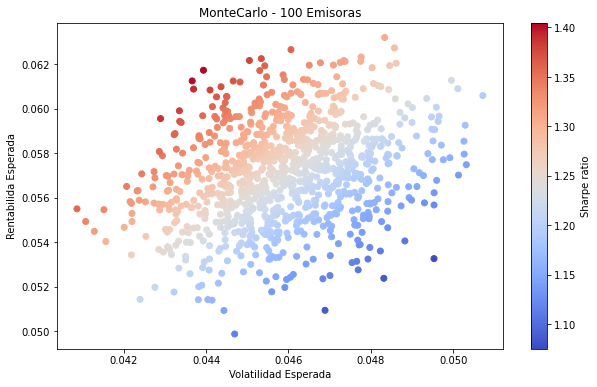

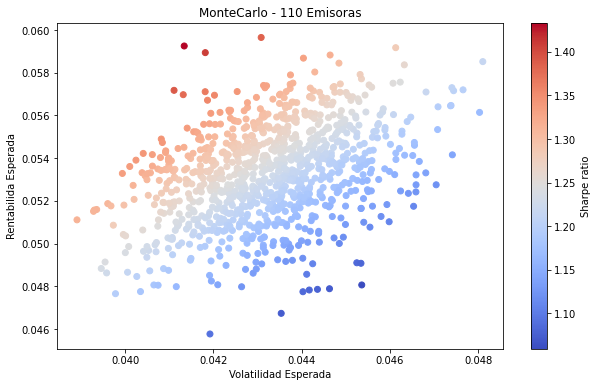

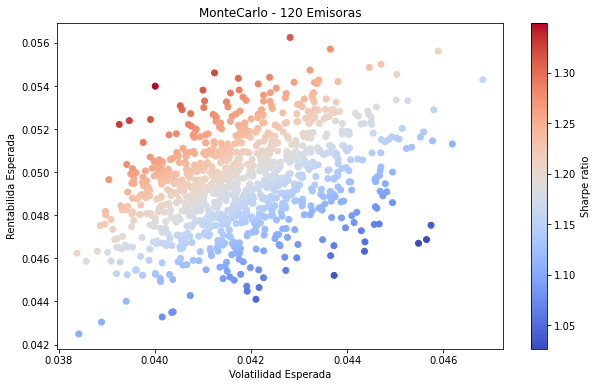

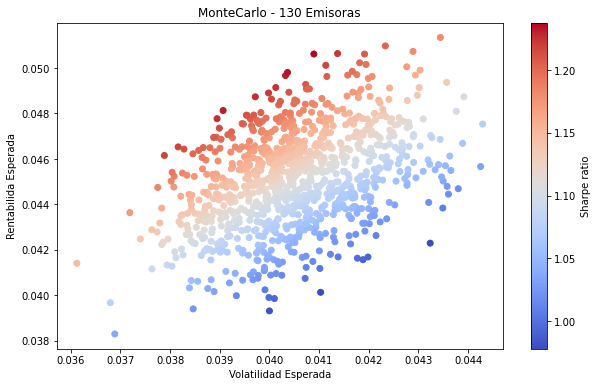

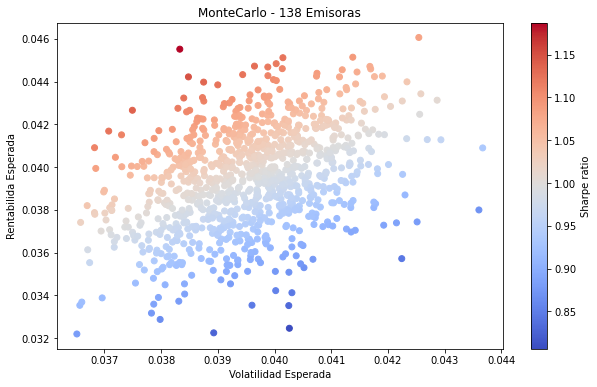

In [ ]:
for i in range(10,150,10):
  lista =top(rend,i)
  MonteCarlo(rend[lista],1000)

#Pruebas del Modelo Red Neuronal

Entrenamiento del modelo en 10 pruebas y portafolio de inversión creados con 50 emisoras

In [ ]:
acc,acct,cacc,cacct=comparativo('/content/precios.csv',lista_emp,fecha_inicio,fecha_final,50,10)

Se han truncado las últimas 5000 líneas del flujo de salida.
6/6 [==============================] - 0s 4ms/step - loss: 0.4628 - accuracy: 0.8258
Modelo Actualizado Guardado..
6/6 [==============================] - 0s 3ms/step - loss: 0.4860 - accuracy: 0.8315
Modelo Actualizado Guardado..
6/6 [==============================] - 0s 3ms/step - loss: 0.4871 - accuracy: 0.8371
Modelo Actualizado Guardado..
6/6 [==============================] - 0s 3ms/step - loss: 0.4179 - accuracy: 0.8539
Modelo Actualizado Guardado..
6/6 [==============================] - 0s 5ms/step - loss: 0.3739 - accuracy: 0.8596
Modelo Actualizado Guardado..
6/6 [==============================] - 0s 3ms/step - loss: 0.3809 - accuracy: 0.8708
Modelo Actualizado Guardado..
6/6 [==============================] - 0s 3ms/step - loss: 0.3472 - accuracy: 0.8764
Modelo Actualizado Guardado..
6/6 [==============================] - 0s 6ms/step - loss: 0.4500 - accuracy: 0.7921
Red Multicapa
Training clase    0.79992
dtype: fl

#Representación Gráfica de Accuracy en pruebas para una Red Multicapa

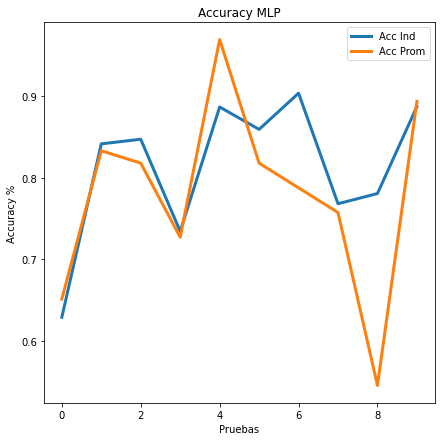

In [ ]:
plt.figure(figsize=(7,7))
x=range(10)
plt.plot(x,acc,label='Acc Ind',linewidth=3)
plt.plot(x,acct,label='Acc Prom',linewidth=3)
plt.title('Accuracy MLP')
plt.xlabel('Pruebas')
plt.ylabel('Accuracy %')
plt.legend()


#Representación Gráfica de Accuracy en pruebas para una Red Convolucional

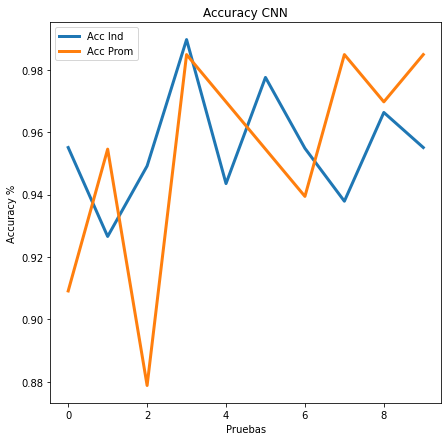

In [ ]:
plt.figure(figsize=(7,7))
x=range(10)
plt.plot(x,cacc,label='Acc Ind',linewidth=3)
plt.plot(x,cacct,label='Acc Prom',linewidth=3)
plt.title('Accuracy CNN')
plt.xlabel('Pruebas')
plt.ylabel('Accuracy %')
plt.legend()


#Representación Gráfica de Accuracy en pruebas para una Red Multicapa vs Red Convolucional

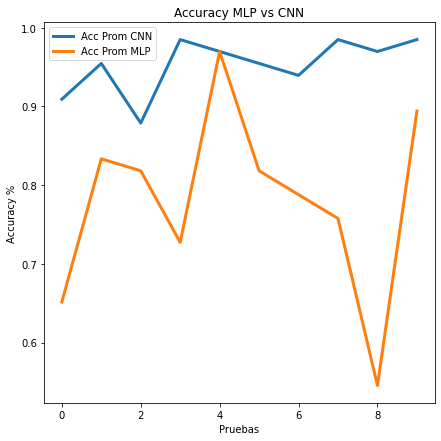

In [ ]:
plt.figure(figsize=(7,7))
x=range(10)
plt.plot(x,cacct,label='Acc Prom CNN',linewidth=3)
plt.plot(x,acct,label='Acc Prom MLP',linewidth=3)
plt.title('Accuracy MLP vs CNN')
plt.xlabel('Pruebas')
plt.ylabel('Accuracy %')
plt.legend()
